In [129]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import skimage
import torch.nn as nn
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
	# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *


ORIGINAL_WIDTH = 2560
ORIGINAL_HEIGHT = 1920

# AUGMENTATION VARIABLES
CROP_SIZE = 1000
RANDOM_ROTATION = random.randint(0, 180)
RANDOM_SHIFT = 2
RANDOM_BRIGHTNESS = random.randint(0,10)
RANDOM_CONTRAST = random.randint(0,10)
RANDOM_90_DEG_TURN = 1

arch = resnet50     
BATCH_SIZE = 20
sz = 64
MODEL_PATH = str(arch).split()[1]

def readCroppedImage(path, augmentations = True):    

    bgr_img = cv2.imread('.'+path)
    cv2.waitKey()
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(augmentations):
    
        #random rotation
        rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
        if(RANDOM_90_DEG_TURN == 1):
            rotation += random.randint(-1,1) * 90
        M = cv2.getRotationMatrix2D((ORIGINAL_WIDTH/2,ORIGINAL_HEIGHT/2),rotation,1)   # the center point is the rotation anchor
        rgb_img = cv2.warpAffine(rgb_img,M,(ORIGINAL_WIDTH,ORIGINAL_HEIGHT))

        #random x,y-shift
        x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
        y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
                    
        # Random flip
        flip_hor = bool(random.getrandbits(1))
        flip_ver = bool(random.getrandbits(1))
        if(flip_hor):
            rgb_img = rgb_img[:, ::-1]
        if(flip_ver):
            rgb_img = rgb_img[::-1, :]

        # Random brightness
        br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
        rgb_img = rgb_img + br

        # Random contrast
        cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
        rgb_img = rgb_img * cr
    
    # Random crop to center and normalization
    start_width = random.randint(0, ORIGINAL_WIDTH - CROP_SIZE)
    end_width = start_width + CROP_SIZE
    start_height = random.randint(0, ORIGINAL_HEIGHT -CROP_SIZE)
    end_height = start_height + CROP_SIZE
    rgb_img = rgb_img[start_height:end_height, start_width:end_width] / 255

    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    # Down sample to input size
    rgb_img = cv2.resize(rgb_img, (sz,sz))
    
    return rgb_img

def readImage(path):
	bgr_img = cv2.imread(path)
	b,g,r = cv2.split(bgr_img)
	rgb_img = cv2.merge([r,g,b])
	return rgb_img


# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('//','/'), augmentations = False)
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))

# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return cnn_learner(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

      id  label
0      1      0
1      2      1
2      3      1
3      4      0
4      5      0
..   ...    ...
96    97      0
97    98      1
98    99      1
99   100      0
100  101      1

[101 rows x 2 columns]
0    56
1    45
Name: label, dtype: int64
./image/train/53 neg
./image/train/5 neg
./image/train/84 neg
./image/train/90 neg
./image/train/19 neg
./image/train/49 pos
./image/train/75 pos
./image/train/32 pos
./image/train/94 pos
./image/train/34 pos


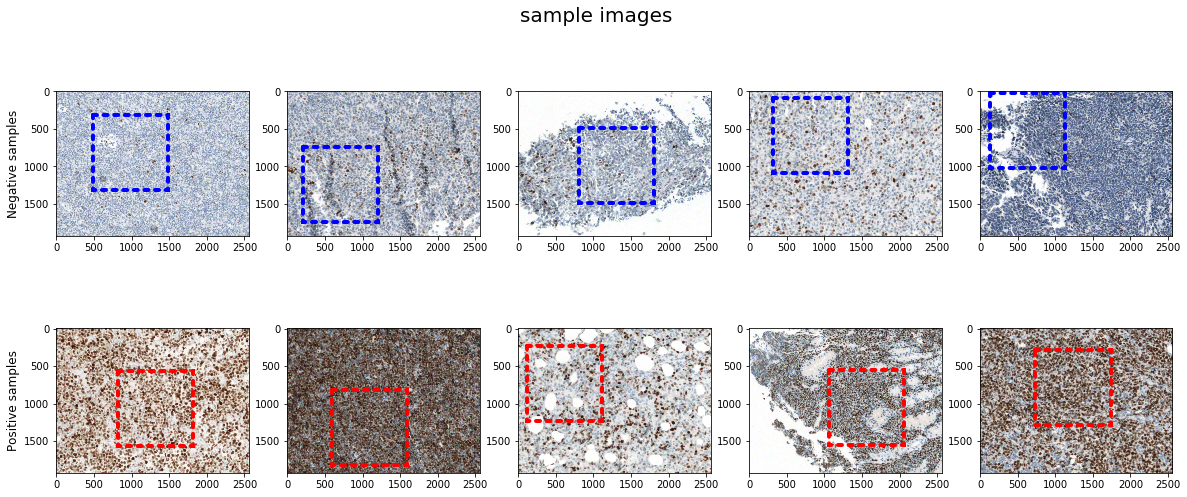

In [130]:
data = pd.read_csv('./labels.csv')
train_path = './image/train/'
test_path = './image/test/'
# quick look at the label stats
print(data)
print(data['label'].value_counts())


# random sampling
random.seed(4)
shuffled_data = shuffle(data)

if True:
    fig, ax = plt.subplots(2,5, figsize=(20,8))
    fig.suptitle('sample images',fontsize=20)
    # Negatives
    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
        path = os.path.join(train_path, str(idx))
        print(path, "neg")
        ax[0,i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        box = patches.Rectangle((random.randint(0, ORIGINAL_WIDTH-CROP_SIZE),random.randint(0, ORIGINAL_HEIGHT-CROP_SIZE)),CROP_SIZE,CROP_SIZE,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
        ax[0,i].add_patch(box)
    ax[0,0].set_ylabel('Negative samples', size='large')
    # Positives
    for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
        path = os.path.join(train_path, str(idx))
        print(path, "pos")
        ax[1,i].imshow(readImage(path + '.tif'))
        # Create a Rectangle patch
        box = patches.Rectangle((random.randint(0, ORIGINAL_WIDTH-CROP_SIZE),random.randint(0, ORIGINAL_HEIGHT-CROP_SIZE)),CROP_SIZE,CROP_SIZE,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
        ax[1,i].add_patch(box)
    ax[1,0].set_ylabel('Positive samples', size='large')
 

In [131]:
# count the statistics
if False:
    x_tot = np.zeros(3)
    x2_tot = np.zeros(3)
    counted_ones = 0
    for i, idx in tqdm_notebook(enumerate(shuffled_data['id']), 'computing statistics...'):
        path = os.path.join(train_path, str(idx))
        imagearray = readImage(path + ".tif").reshape(-1,3)
        print(imagearray, np.max(imagearray, axis=0))
        print(imagearray.mean(axis=0), (imagearray**2).mean(axis=0))
        break
        x_tot += imagearray.mean(axis=0)
        x2_tot += (np.power(imagearray,2)).mean(axis=0)
        counted_ones += 1

    channel_avr = x_tot/counted_ones
    print(x_tot, x2_tot, counted_ones, channel_avr)
    channel_std = np.sqrt((x2_tot/counted_ones) - (channel_avr**2))
    print("channel average: ",channel_avr)
    print("channel standard deviation: ",channel_std)


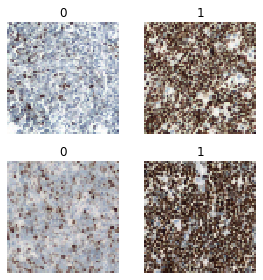

In [132]:

train_df = data.set_index('id')

train_names = train_df.index.values.astype(str)
train_labels = np.asarray(train_df['label'].values)

tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

# create dataframe for the fastai loader
train_dict = {'name': np.core.defchararray.add(train_path, train_names), 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        .split_by_idx(val_idx)
        .label_from_df(cols='label')
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        .databunch(bs=BATCH_SIZE)
        .normalize()
       )

# check that the imgDataBunch is loading our images ok
imgDataBunch.show_batch(rows=2, figsize=(4,4))

In [133]:
# Choose learning rate decay value
if False:
    lrs = []
    losses = []
    wds = []
    iter_count = 600
    learner = getLearner()

    # WEIGHT DECAY = 1e-6
    learner.lr_find(wd=1e-6, num_it=iter_count)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)
    wds.append('1e-6')
    learner = getLearner() #reset learner - this gets more consistent starting conditions

    # WEIGHT DECAY = 1e-4
    learner.lr_find(wd=1e-4, num_it=iter_count)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)
    wds.append('1e-4')
    learner = getLearner() #reset learner - this gets more consistent starting conditions

    # WEIGHT DECAY = 1e-2
    learner.lr_find(wd=1e-2, num_it=iter_count)
    lrs.append(learner.recorder.lrs)
    losses.append(learner.recorder.losses)
    wds.append('1e-2')
    learner = getLearner() #reset learner

    # Plot weight decays
    _, ax = plt.subplots(1,1)
    min_y = 0.5
    max_y = 0.55
    for i in range(len(losses)):
        ax.plot(lrs[i], losses[i])
        min_y = min(np.asarray(losses[i]).min(), min_y)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Learning Rate")
    ax.set_xscale('log')
    #ax ranges may need some tuning with different model architectures 
    ax.set_xlim((1e-3,3e-1))
    ax.set_ylim((min_y - 0.02,max_y))
    ax.legend(wds)
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [134]:
# See raw pre-trained model performence
learner = getLearner()
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.4545454680919647 %.


epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,1.017446,0.682595,0.727273,00:02
0,1.017446,0.682595,0.727273,00:02
1,1.238437,4.629739,0.727273,00:02
1,1.238437,4.629739,0.727273,00:02
2,1.285385,29.690704,0.454545,00:02
2,1.285385,29.690704,0.454545,00:02
3,1.173777,1.852979,0.818182,00:02
3,1.173777,1.852979,0.818182,00:02
4,1.080357,0.800268,0.545455,00:02


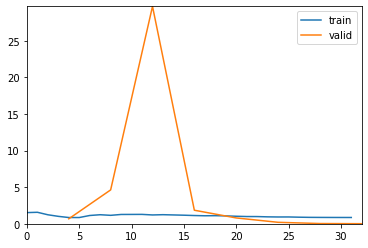

In [135]:
# Minimum viable product
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

The accuracy is 0.9090909361839294 %.


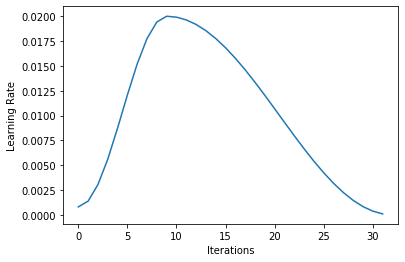

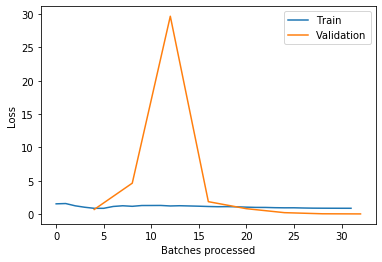

In [136]:
# Evaluate baseline model
learner.recorder.plot_lr()
learner.recorder.plot_losses()
preds,y, loss = learner.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


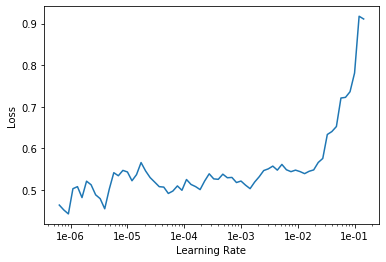

In [137]:
# Fine-tuning 
learner.load(MODEL_PATH + '_stage1')
learner.unfreeze()
learner.lr_find(wd=wd)
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
epoch,train_loss,valid_loss,accuracy,time
0,0.692624,0.504188,0.818182,00:02
0,0.692624,0.504188,0.818182,00:02
1,0.590573,0.486606,0.909091,00:02
1,0.590573,0.486606,0.909091,00:02
2,0.520352,0.013344,1.000000,00:02
2,0.520352,0.013344,1.000000,00:02
3,0.499010,0.199134,0.909091,00:02
3,0.499010,0.199134,0.909091,00:02
4,0.531474,0.024322,1.000000,00:02


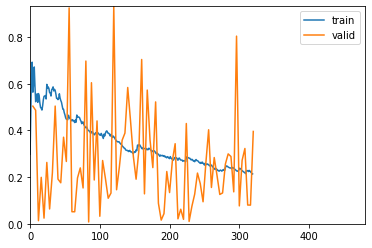

In [ ]:
learner.fit_one_cycle(cyc_len=120, max_lr=slice(1e-5,1e-4))

In [ ]:
# Evaluate final model
learner.recorder.plot_losses()
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')
preds,y, loss = learner.get_preds(with_loss=True, ds_type=DatasetType.Train)
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

In [ ]:
learner.save(MODEL_PATH + '_stage2')

In [ ]:
learner.load(MODEL_PATH + '_stage2')
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

In [ ]:

def imageToTensorImage(path):
    '''
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    rgb_img = cv2.resize(rgb_img, (sz,sz))
    # crop to center to the correct size and convert from 0-255 range to 0-1 range
    #H,W,C = rgb_img.shape
    #rgb_img = rgb_img[(H-sz)//2:(sz +(H-sz)//2),(H-sz)//2:(sz +(H-sz)//2),:] / 256
    '''
    rgb_img = readCroppedImage(path,False)
    rgb_img = cv2.resize(rgb_img, (CROP_SIZE, CROP_SIZE))
    
    return vision.Image(px=pil2tensor(rgb_img, np.float32))

img = imageToTensorImage('/image/test/102.tif')

## predict and visualize
img.show(y=learner.predict(img)[0])
classes = ['negative', 'positive']
print('This is a ' + classes[int(learner.predict(img)[0])] + ' image.')

In [ ]:
# Testing accuracy
n_patch = 10
test_path = './image/test/'
test_patch_path = '/image/test_patch/test_'
fname_list = []
for fname in sorted(os.listdir(test_path)):
    fname_list.append(fname)
    
test_label = pd.read_csv('./test_labels.csv')
test_df = test_label.set_index('id')
test_name = test_df.index.values.astype(str)
test_labels = np.asarray(test_df['label'].values)
print(test_name)
print(test_labels)

for i in test_name:
    patch_preds = np.zeros(n_patch)
    for p in range(1, n_patch+1):
        patch_path = test_patch_path + str(p) + '/' + i + '.tif'
        print(patch_path)
        patch = imageToTensorImage(patch_path)
        patch_preds[p-1] = int(learner.predict(img)[0])
    print(patch_preds)